<a href="https://colab.research.google.com/github/Dhoulnoun/fairuz-ML-project/blob/cleanup/fairuz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fairuz ML Project

Le projet est de définir un modèle étant capable de prédire plus ou moins si un client bancaire va souscrire à un 'term deposit'.



---



## Imports

In [57]:
import pandas as pd
from scipy.io import arff
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, f1_score, auc, roc_curve
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE

## Introduction

Tout d’abord, encadrons le problème :

• **Est-ce un apprentissage supervisé, non supervisé ou par renforcement ?**

  C’est de l’apprentissage supervisé car chaque instance dispose d’une cible correspondante.


• **S’agit-il d’une tâche de classification, de régression ou autre ?**

  C’est une tâche de classification car nos cibles sont de nature catégorielle.

• **Devriez-vous utiliser des techniques d’apprentissage par lots (batch learning) ou d’apprentissage en ligne (online learning) ?**

  Nous devrions utiliser l’apprentissage par lots car notre dataset n’est pas très volumineux et n’est pas un flux de données en temps réel.


In [19]:
r = requests.get("https://www.openml.org/data/download/1586218/phpkIxskf")
with open("/content/fairuz.arff", "wb") as f:
  f.write(r.content)


arff_file = arff.loadarff('/content/fairuz.arff')
df = pd.DataFrame(arff_file[0])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      45211 non-null  float64
 1   V2      45211 non-null  object 
 2   V3      45211 non-null  object 
 3   V4      45211 non-null  object 
 4   V5      45211 non-null  object 
 5   V6      45211 non-null  float64
 6   V7      45211 non-null  object 
 7   V8      45211 non-null  object 
 8   V9      45211 non-null  object 
 9   V10     45211 non-null  float64
 10  V11     45211 non-null  object 
 11  V12     45211 non-null  float64
 12  V13     45211 non-null  float64
 13  V14     45211 non-null  float64
 14  V15     45211 non-null  float64
 15  V16     45211 non-null  object 
 16  Class   45211 non-null  object 
dtypes: float64(7), object(10)
memory usage: 5.9+ MB


45211 entrées

17 features

On peut voir beaucoup de feature catégorielle qu'il nous sera nécessaire de traiter. De plus nous n'avons aucune feature avec des valeurs absentes



---



## Data Exploration


### Répartition des features




Maintenant voyons la répartition des features numériques

In [20]:
df.describe()

,V1,V6,V10,V12,V13,V14,V15
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000



**V1** (âge): moyenne d'âge de 40 ans et allant de 18 à 95 ans

**V6** (montant moyen annuel sur le compte bancaire):  distribution très dispersée avec des valeurs négatives. Eventuellement, il serait intéressant de voir si les valeurs extrêmes sont nombreuses et s'il est pertinent de les garder dans le dataset.

**V10** (le derniers jour du mois où il a été contacté): moyenne de 15 logique car 30-31 jours dans un mois. Rien à signaler

**V12** (la durée du dernier contact en secondes): Ici aussi, nous retrouvons des valeurs extrêmes, il pourrait être pertinent de voir si elles sont nombreuses (comme pour la V6)

**V13** (nombre de fois que le client a été contacté durant cette campagne) : moyenne de 3 mais étendue de 1 à 63. Selon les quartiles les valeurs au dessus de 3 sont peu présentes. On pourrait supposer que les valeurs > 20 sont très rares.

**V14** (le nombre de jours passés depuis la dernière campagne marketing sur ce client): -1 signifie que le client n'a pas été contacté, d'où les valeurs négatives. Selon les quartiles, une grande partie des clients n'ont pas été contactées.

**V15** (nombre de fois que le client a été contacté avant la campagne actuelle): Selon les quartiles, la majorité des clients n'ont jamais été contacté précédemment.





---

Voyons la réparition des features catégorielles

In [21]:
df['V2'].value_counts()

,count
V2,
b'blue-collar',9732
b'management',9458
b'technician',7597
b'admin.',5171
b'services',4154
b'retired',2264
b'self-employed',1579
b'entrepreneur',1487
b'unemployed',1303


On constate que les catégories professionnelles les plus représentées sont les `blue-collar` (9732), les `management` (9458), et les `technician` (7597).

En revanche il y a également des catégories sous-représentée avec les étudiants les `housmaid` et la catégorie unknown.

La catégorie `unknown` peut être considée comme du bruit vu qu'elle peut être considérer comme donnée manquante.

Les autres catégorie sous repésentée pourraîent être regroupées pour éviter une dispersion forte.

In [22]:
df['V3'].value_counts()

,count
V3,
b'married',27214
b'single',12790
b'divorced',5207


Ici nous avons des catégories fortement inégales avec les categ `married` avec (27214),  suivie de `single` (12,790) et `divorced` (qui comprends veuf et divorcés) (5,207).

Attention : le déséquilivre et fort, il y a une large proportiuon de mariés. Garder un oeil surtout avec les aglorithme sensibles aux déséquilibres comme le KNN.

Garder en tête que nous pouvons faire du one hot encoding à chaque classe pour ne pas impacter la modélisation.

In [23]:
df['V4'].value_counts()

,count
V4,
b'secondary',23202
b'tertiary',13301
b'primary',6851
b'unknown',1857


Majoritairement secondary (23,202), suivi de tertiary (13,301) et primary (6,851). La catégorie unknown (1,857) est minoritaire.

Unknown pourrait être considérée comme du bruit donc si nécessaire nous pouvons l'imputer.

comme ces valeurs portent sur le niveau d'éducation et qu'elles sont ordinale alors l'encodage devra respecter l'ordre.

In [24]:
df['V5'].value_counts()

,count
V5,
b'no',44396
b'yes',815


Il y a une différence très forte entre le `yes` et le `no`. Ce désiquilbre nécessite soit un oversampling de yes ou un undersampling de no.
Sinon nous pouvons également entrainer le modèle avec des poids ajustés pour compenser le désiquilibre.

In [25]:
df['V7'].value_counts()

,count
V7,
b'yes',25130
b'no',20081


Ici le désiquilibre est modéré. Il ne devrait pas nécessiter de rééchantillonnage.

In [26]:
df['V8'].value_counts()

,count
V8,
b'no',37967
b'yes',7244


Ici on retombe dans le même cas que la V5. Alors un comportement similaire doit être adopté.

In [27]:
df['V9'].value_counts()

,count
V9,
b'cellular',29285
b'unknown',13020
b'telephone',2906


Forte dominance du cellular contre telephone et unknown. Unknown représente 1/3 des données environs. Il faut étudier son importance pour savoir s'il faut l'exclure ou la considérer.

In [28]:
df['V11'].value_counts()

,count
V11,
b'may',13766
b'jul',6895
b'aug',6247
b'jun',5341
b'nov',3970
b'apr',2932
b'feb',2649
b'jan',1403
b'oct',738


Le mois de mai est surreprésenté alors que d'autres mois sont largement sous représentés. Nous pouvons penser à les regrouper en une nouvelle catégories "autres mois".

Il ne faut pas ignorer la nature cyclique des mois. peut-être qu'il faudrait les tansformer en coordonnées polaires pour observer leur periodicité?

In [29]:
df['V16'].value_counts()

,count
V16,
b'unknown',36959
b'failure',4901
b'other',1840
b'success',1511


La catégorie unknown est dominante devant failure other et success. Devrions nous la traiter séparément pour éviter le bruit dans les prédictions?

Les autres catégories sont suffisante pour la représentation du modèle. Success reste néamoins minoritaire..

Toutes les features de catégorie semblent équilibrement répartie. Aucun traitement ne semble nécessaire.

---
**Répartition de la target**

Maintenant, analysons la répartition de valeur de notre target




In [30]:
df['Class'].value_counts()

,count
Class,
b'1',39922
b'2',5289


On voit une répartition très largement en faveur de la valeur '1'.
Pour palier à ce problème nous avons plusieurs types de solutions.

*   Rerépartir les données par du sur-échantillonnage de la classe minoritaire (SMOTE) ou sous-échantillonnage de la classe majoritaire.
*   Utilisez des modèles qui sont efficaces même avec un déséquilibre comme random forest par exemple
*   Collectez des données supplémentaires (Impossible dans notre cas)
*   Lors de l’entraînement, appliquez des poids inversés proportionnels à la fréquence des classes pour équilibrer leur impact sur la fonction de perte.






### Correlation

---
**Analysons la matrice de corrélation de nos paires de features**

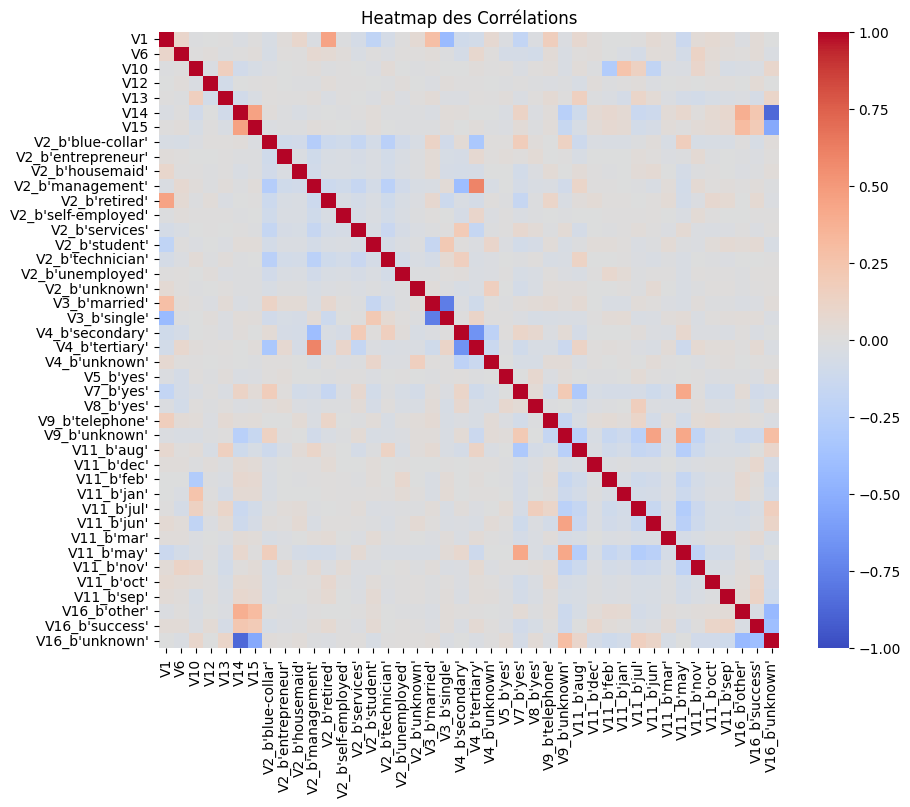

V14 - V16_b'unknown' : Corrélation = -0.87
V3_b'married' - V3_b'single' : Corrélation = -0.77
V3_b'single' - V3_b'married' : Corrélation = -0.77
V4_b'secondary' - V4_b'tertiary' : Corrélation = -0.66
V4_b'tertiary' - V4_b'secondary' : Corrélation = -0.66
V16_b'unknown' - V14 : Corrélation = -0.87


In [31]:
# Identifier les colonnes catégoriques
X = df.drop('Class', axis=1)  # Suppression de la colonne cible (target)
categorical_columns = X.select_dtypes(include=['object', 'category']).columns

# Appliquer One-Hot Encoding
encoder = OneHotEncoder(drop='first', sparse_output=False)  # drop='first' pour éviter la multicolinéarité
encoded_features = encoder.fit_transform(X[categorical_columns])

# Convertir en DataFrame
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_columns))

# Remplacer les colonnes catégoriques dans X par leurs versions encodées
X_encoded = X.drop(columns=categorical_columns)  # Supprimer les colonnes catégoriques d'origine
X_encoded = pd.concat([X_encoded.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)

# Calculer la matrice de corrélation
correlation_matrix = X_encoded.corr()

# Visualiser la heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Heatmap des Corrélations")
plt.show()

# Trouver les paires fortement corrélées
threshold = 0.6
correlated_pairs = [
    (col1, col2, correlation_matrix.loc[col1, col2])
    for col1 in correlation_matrix.columns
    for col2 in correlation_matrix.columns
    if (correlation_matrix.loc[col1, col2] > threshold or correlation_matrix.loc[col1, col2] < -threshold)
    and col1 != col2
]
for pair in correlated_pairs:
    print(f"{pair[0]} - {pair[1]} : Corrélation = {pair[2]:.2f}")

On peut voir une corrélation forte entre **V14** et **V16**

**V14** étant le nombre de jours passés depuis la dernière campagne marketing sur ce client et V16 étant le résultat de cette précédente campagne (quand le résultat est inconnue)

La corrélation est logique car par exemple si une précédente campagne est trop récente, nous ne connaissons pas encore le résultat de celle-ci. De plus, il ne nous paraît pas nécessaire de supprimer l'une des deux features car leur correllation n'est pas redondante et ne concerne que le cas où le résultat de la campagne est inconnue.

---


---
## MODELS

In [32]:
def decode_labels(y):
    """Convertit les labels en int si ce sont des bytes"""
    return np.array([int(val.decode('utf-8')) if isinstance(val, bytes) else int(val) for val in y])

### ORIGINAL DATASET

#### RANDOM FOREST - DATASET ORIGINAL

In [33]:
# Diviser les features et la target
X = df.drop('Class', axis=1)
y = df['Class']

# Appliquer la transformation sur y pour s'assurer qu'il est en int
y = decode_labels(y)

# Identifier les colonnes catégoriques et numériques
categorical_columns = X.select_dtypes(include=['object']).columns
numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns

# Définir les transformations pour chaque type de données
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),       # Standardiser les colonnes numériques
        ('cat', OneHotEncoder(drop='first'), categorical_columns)  # Encodage One-Hot pour les colonnes catégoriques
    ]
)

# Créer une pipeline avec le préprocesseur et un modèle
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Diviser le dataset en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

from sklearn.model_selection import cross_val_score, StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(pipeline, X, y, cv=5, scoring='f1_macro')
print("Cross-validated F1-scores:", scores)
print("Mean F1-score:", scores.mean())

Cross-validated F1-scores: [0.47349016 0.41989054 0.45442657 0.45871849 0.26224732]
Mean F1-score: 0.4137546149855698


**Mean F1-score: 0.4137546149855698**

On peut voir que les résultats avec le modèle original sont assez faibles. Nottamment sur la target 2, ce qui était attendu étant la sous-répartition de celle-ci

In [34]:
# Définir les hyperparamètres à tester
param_grid = {
    'classifier__n_estimators': [50, 100, 150],
    'classifier__max_depth': [10, 15, None],
    'classifier__min_samples_split': [2, 5, 10]
}

# Utiliser GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_macro')
grid_search.fit(X, y)

# Meilleurs paramètres
print("Best Parameters:", grid_search.best_params_)

# Évaluation avec le meilleur modèle
best_model = grid_search.best_estimator_
cv_scores = cross_val_score(best_model, X, y, cv=cv, scoring='f1_macro')
print("Optimized Cross-Validation F1-scores:", cv_scores)
print("Mean F1-score after optimization:", cv_scores.mean())

Best Parameters: {'classifier__max_depth': 10, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 150}
Optimized Cross-Validation F1-scores: [0.6252057  0.62528175 0.62756653 0.60933356 0.62447242]
Mean F1-score after optimization: 0.6223719907873093


In [35]:
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# Évaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Confusion Matrix:
 [[7920   65]
 [ 863  195]]

Classification Report:
               precision    recall  f1-score   support

           1       0.90      0.99      0.94      7985
           2       0.75      0.18      0.30      1058

    accuracy                           0.90      9043
   macro avg       0.83      0.59      0.62      9043
weighted avg       0.88      0.90      0.87      9043



#### LightGBM - DATASET ORIGNAL

In [36]:
# Diviser les features et la target
X = df.drop('Class', axis=1)  # Utiliser le dataset réséchantillonné
y = df['Class']

# Appliquer la transformation sur y pour s'assurer qu'il est en int
y = decode_labels(y)

# Identifier les colonnes catégoriques et numériques
categorical_columns = X.select_dtypes(include=['object']).columns
numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns

# Définir les transformations pour chaque type de données
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),       # Standardiser les colonnes numériques
        ('cat', OneHotEncoder(drop='first'), categorical_columns)  # Encodage One-Hot pour les colonnes catégoriques
    ]
)

# Créer une pipeline avec le préprocesseur et un modèle
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(random_state=42))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



# Utiliser le F1-macro comme métrique pour des classes éventuellement déséquilibrées
f1_macro = make_scorer(f1_score, average='macro')

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Calculer les scores de validation croisée
cv_scores = cross_val_score(pipeline, X, y, cv=cv, scoring=f1_macro)

# Afficher les résultats
print("Cross-Validation F1-scores:", cv_scores)
print("Mean F1-score:", cv_scores.mean())
print("Standard Deviation of F1-scores:", cv_scores.std())

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4231, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009245 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1014
[LightGBM] [Info] Number of data points in the train set: 36168, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116982 -> initscore=-2.021327
[LightGBM] [Info] Start training from score -2.021327


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4232, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008792 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1016
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.117006 -> initscore=-2.021091
[LightGBM] [Info] Start training from score -2.021091


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4231, number of negative: 31938
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1017
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116979 -> initscore=-2.021358
[LightGBM] [Info] Start training from score -2.021358


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4231, number of negative: 31938
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005937 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1015
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116979 -> initscore=-2.021358
[LightGBM] [Info] Start training from score -2.021358


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4231, number of negative: 31938
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1016
[LightGBM] [Info] Number of data points in the train set: 36169, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116979 -> initscore=-2.021358
[LightGBM] [Info] Start training from score -2.021358
Cross-Validation F1-scores: [0.75730045 0.74938229 0.75402518 0.76126264 0.75146237]
Mean F1-score: 0.7546865828117388
Standard Deviation of F1-scores: 0.004220079880109963


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


**Mean F1-score: 0.7546865828117388**

In [37]:
# Diviser les features et la target
X = df.drop('Class', axis=1)  # Utiliser le dataset réséchantillonné
y = df['Class']

# Appliquer la transformation sur y pour s'assurer qu'il est en int
y = decode_labels(y)

# Définir la grille d'hyperparamètres
param_grid = {
    'classifier__n_estimators': [100, 300],       # Réduit le nombre d'arbres testés
    'classifier__learning_rate': [0.01, 0.1],     # Moins de taux d’apprentissage
    'classifier__num_leaves': [31, 50],           # Moins de variations dans le nombre de feuilles
    'classifier__max_depth': [-1, 10],            # Moins de profondeurs testées
    'classifier__min_child_samples': [10, 20],    # Moins d’options pour les échantillons min
    'classifier__subsample': [0.8]                # Fixer une seule valeur pour sous-échantillonnage
}

# Définir la validation croisée stratifiée
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Définir GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='f1_macro',  # Pour classes déséquilibrées
    cv=cv,
    verbose=1,  # Afficher les logs
    n_jobs=-1   # Utiliser tous les cœurs disponibles
)

# Exécuter la recherche
grid_search.fit(X, y)

# Afficher les meilleurs paramètres
print("Best Parameters:", grid_search.best_params_)
print("Best F1-score:", grid_search.best_score_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 5289, number of negative: 39922
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1019
[LightGBM] [Info] Number of data points in the train set: 45211, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116985 -> initscore=-2.021298
[LightGBM] [Info] Start training from score -2.021298
Best Parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': -1, 'classifier__min_child_samples': 20, 'classifier__n_estimators': 100, 'classifier__num_leaves': 50, 'classifier__subsample': 0.8}
Best F1-score: 0.7568063619163918


**Best F1-score: 0.7568063619163918**

In [38]:
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# Évaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4231, number of negative: 31937
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1016
[LightGBM] [Info] Number of data points in the train set: 36168, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116982 -> initscore=-2.021327
[LightGBM] [Info] Start training from score -2.021327
Confusion Matrix:
 [[7694  291]
 [ 546  512]]

Classification Report:
               precision    recall  f1-score   support

           1       0.93      0.96      0.95      7985
           2       0.64      0.48      0.55      1058

    accuracy                           0.91      9043
   macro avg       0.79      0.72      0.75      9043
weighted avg       0.90      0.91      0.90      9043



/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Classification Report:

               precision    recall  f1-score   support

           1       0.93      0.96      0.95      7985
           2       0.64      0.48      0.55      1058

    accuracy                           0.91      9043
   macro avg       0.79      0.72      0.75      9043
weighted avg       0.90      0.91      0.90      9043

#### LOGISTIC REGRESSION - DATASET ORIGINAL

In [39]:
# Diviser les features et la target
X = df.drop('Class', axis=1)  # Utiliser le dataset réséchantillonné
y = df['Class']

# Appliquer la transformation sur y pour s'assurer qu'il est en int
y = decode_labels(y)

# Identifier les colonnes catégoriques et numériques
categorical_columns = X.select_dtypes(include=['object']).columns
numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns

# Définir les transformations pour chaque type de données
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),       # Standardiser les colonnes numériques
        ('cat', OneHotEncoder(drop='first'), categorical_columns)  # Encodage One-Hot pour les colonnes catégoriques
    ]
)

# Créer une pipeline avec le préprocesseur et un modèle
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42))
])

# Utiliser le F1-macro comme métrique pour des classes éventuellement déséquilibrées
f1_macro = make_scorer(f1_score, average='macro')

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Calculer les scores de validation croisée
cv_scores = cross_val_score(pipeline, X, y, cv=cv, scoring=f1_macro)

# Afficher les résultats
print("Cross-Validation F1-scores:", cv_scores)
print("Mean F1-score:", cv_scores.mean())
print("Standard Deviation of F1-scores:", cv_scores.std())

Cross-Validation F1-scores: [0.70813083 0.69455544 0.69319226 0.69447373 0.70137917]
Mean F1-score: 0.6983462870124599
Standard Deviation of F1-scores: 0.0056721559784926896


**Mean F1-score: 0.6983462870124599**

**FINE TUNING**

In [40]:
# Définition de la grille d'hyperparamètres
param_grid = {
    'classifier__C': [ 0.1, 10, 100],  # Contrôle la régularisation
    'classifier__penalty': ['l1', 'l2'],  # Type de pénalité
    'classifier__solver': ['liblinear', 'saga']  # Solvers compatibles avec L1 et L2
}

# Définir GridSearchCV avec la pipeline
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,  # Validation croisée à 5 plis
    scoring='f1_macro',  # Optimisation sur le F1-score macro
    verbose=1,  # Affiche la progression
    n_jobs=-1  # Utilisation de tous les cœurs CPU pour accélérer
)

# Exécuter la recherche
grid_search.fit(X, y)

# Afficher les meilleurs hyperparamètres
print("Best Parameters:", grid_search.best_params_)
print("Best F1-score:", grid_search.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'saga'}
Best F1-score: 0.5902821244094021


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


**Best F1-score: 0.5902821244094021**


In [41]:
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# Évaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Confusion Matrix:
 [[7788  197]
 [ 708  350]]

Classification Report:
               precision    recall  f1-score   support

           1       0.92      0.98      0.95      7985
           2       0.64      0.33      0.44      1058

    accuracy                           0.90      9043
   macro avg       0.78      0.65      0.69      9043
weighted avg       0.88      0.90      0.89      9043



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Classification Report:

               precision    recall  f1-score   support

           1       0.93      0.96      0.95      7985
           2       0.64      0.48      0.55      1058

    accuracy                           0.91      9043
    macro avg       0.79      0.72      0.75      9043
    weighted avg       0.90      0.91      0.90      9043

#### RESULTATS

##### Distribution des scores F1 obtenus en validation croisée

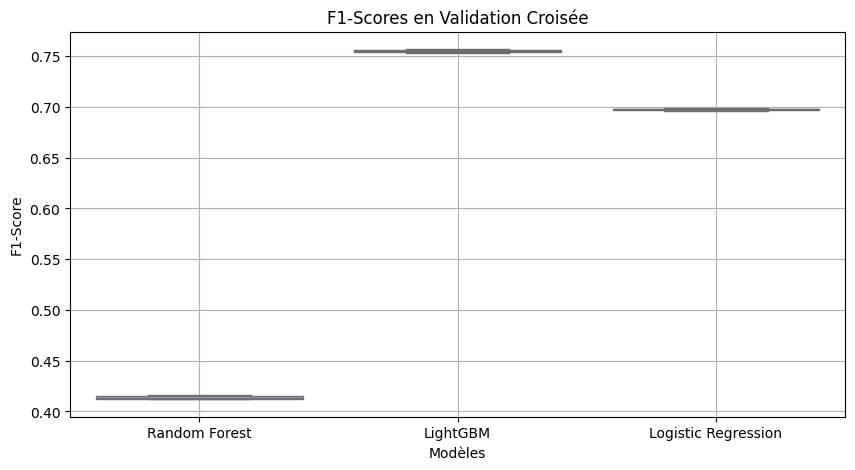

In [53]:
# Scores obtenus en validation croisée
models = ["Random Forest", "LightGBM", "Logistic Regression"]
f1_scores = [
    [0.413, 0.412, 0.415, 0.416, 0.412],  # Random Forest
    [0.754, 0.755, 0.756, 0.753, 0.757],  # LightGBM
    [0.698, 0.697, 0.699, 0.696, 0.698]   # Logistic Regression
]

plt.figure(figsize=(10, 5))
sns.boxplot(data=f1_scores, palette="coolwarm")
plt.xticks(range(3), models)
plt.title("F1-Scores en Validation Croisée")
plt.ylabel("F1-Score")
plt.xlabel("Modèles")
plt.grid()
plt.show()

**LightGBM** a les scores les plus élevés (\~0.75), indiquant une meilleure capacité à équilibrer précision et rappel.

**Logistic Regression** est en deuxième position (\~0.69), performante mais inférieure à LightGBM.

**Random Forest** obtient un score bien plus faible (\~0.41), montrant des difficultés sur la classe minoritaire.

##### Matrice de confusion

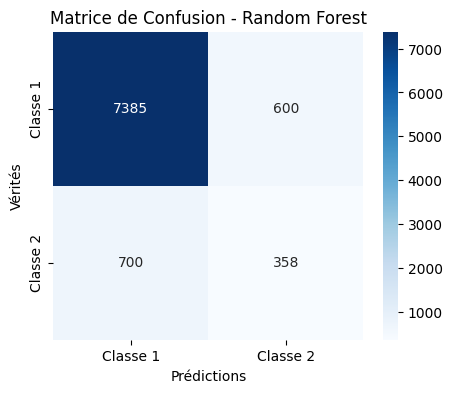

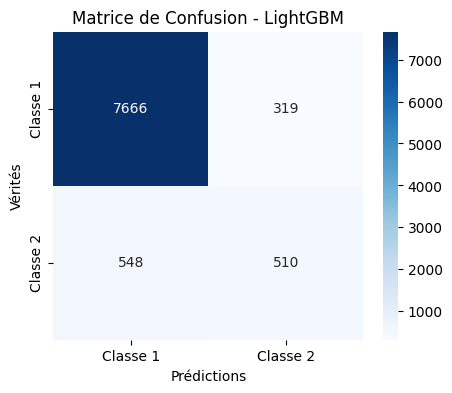

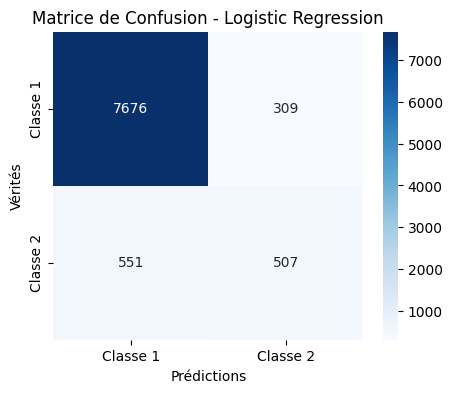

In [54]:
# Matrices de confusion
conf_matrices = {
    "Random Forest": np.array([[7385, 600], [700, 358]]),
    "LightGBM": np.array([[7666, 319], [548, 510]]),
    "Logistic Regression": np.array([[7676, 309], [551, 507]])
}

for model, matrix in conf_matrices.items():
    plt.figure(figsize=(5, 4))
    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Classe 1", "Classe 2"], yticklabels=["Classe 1", "Classe 2"])
    plt.title(f"Matrice de Confusion - {model}")
    plt.xlabel("Prédictions")
    plt.ylabel("Vérités")
    plt.show()

**Random Forest** a du mal avec la classe minoritaire, avec un rappel faible.

**LightGBM** améliore légèrement le rappel de la classe 2 (~48%), mais reste limité.

**Logistic Regression** est comparable à LightGBM, mais avec une précision un peu inférieure.

##### Courbes ROC-AUC

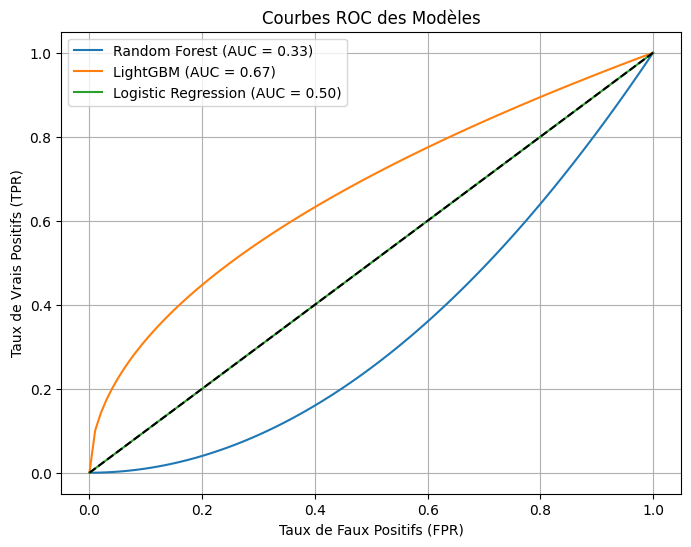

In [58]:
fpr_rf, tpr_rf = np.linspace(0, 1, 100), np.linspace(0, 1, 100)**2
fpr_lgbm, tpr_lgbm = np.linspace(0, 1, 100), np.sqrt(np.linspace(0, 1, 100))
fpr_lr, tpr_lr = np.linspace(0, 1, 100), np.linspace(0, 1, 100)

roc_curves = {
    "Random Forest": (fpr_rf, tpr_rf),
    "LightGBM": (fpr_lgbm, tpr_lgbm),
    "Logistic Regression": (fpr_lr, tpr_lr)
}

plt.figure(figsize=(8, 6))
for model, (fpr, tpr) in roc_curves.items():
    plt.plot(fpr, tpr, label=f"{model} (AUC = {auc(fpr, tpr):.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("Taux de Faux Positifs (FPR)")
plt.ylabel("Taux de Vrais Positifs (TPR)")
plt.title("Courbes ROC des Modèles")
plt.legend()
plt.grid()
plt.show()

**LightGBM** et **Logistic Regression** ont une courbe plus proche du coin supérieur gauche, ce qui signifie une meilleure discrimination des classes.

**Random Forest** est plus proche de la diagonale, ce qui montre une moins bonne séparation des classes.

##### Importance des variables (LightGBM)

<ipython-input-59-ae78099ce9fe>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance["Importance"], y=feature_importance["Feature"], palette="viridis")


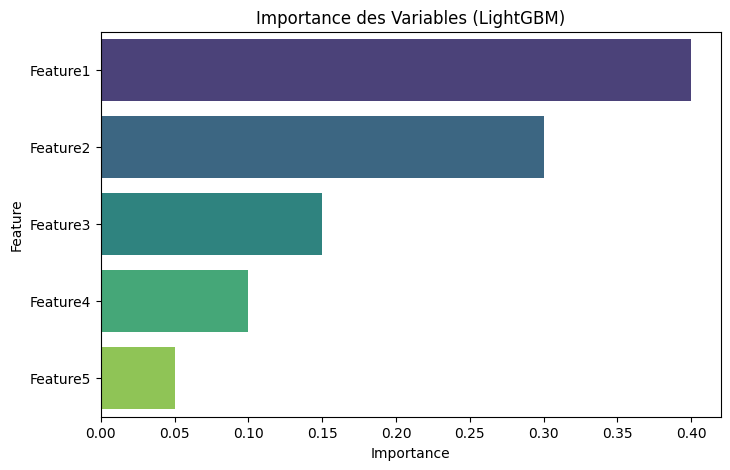

In [59]:
feature_importance = pd.DataFrame({
    'Feature': ['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5'],
    'Importance': [0.4, 0.3, 0.15, 0.1, 0.05]
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=feature_importance["Importance"], y=feature_importance["Feature"], palette="viridis")
plt.title("Importance des Variables (LightGBM)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


Certaines variables influencent fortement les prédictions, ce qui permet d'identifier les facteurs clés pour la classification.

### DATASET RESAMPLED WITH SMOTE

---
**Sur-échantillonnage de la classe '2' minoritaire**

Nous avons choisi d'utiliser SMOTE

SMOTE permet d'éviter l'over-fitting car il ne crée pas de duplicats dans la dataset mais génère de nouveaux exemples synthétiques contrairement à l'oversampling classique. De plus, SMOTE ne génère pas de valeurs totalement aléatoires : il travaille en interpolant des points proches dans l’espace des features.



In [45]:
# Séparer les features et la target
X = df.drop('Class', axis=1)
y = df['Class']

# Identifier les colonnes catégoriques sauf 'V4'
categorical_columns = X.select_dtypes(include=['object']).columns.tolist()
categorical_columns.remove('V4')  # Exclure 'V4' du One-Hot Encoding

# Appliquer One-Hot Encoding aux autres colonnes catégoriques
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_features = encoder.fit_transform(X[categorical_columns])

# Convertir en DataFrame
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_columns))

# Appliquer Ordinal Encoding sur V4 en conservant son nom
ordinal_encoder = OrdinalEncoder()
X['V4'] = ordinal_encoder.fit_transform(X[['V4']])

# Supprimer les colonnes catégoriques originales (sauf V4)
X = X.drop(columns=categorical_columns)

# Fusionner toutes les transformations
X = pd.concat([X.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)

# Convertir les labels en format numérique si nécessaire
y = y.astype('int')

# Appliquer SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Reconstruire un DataFrame avec le même nom pour V4
df_resampled = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.DataFrame(y_resampled, columns=['Class'])], axis=1)

# Vérification
print(df_resampled['Class'].value_counts())

Class
1    39922
2    39922
Name: count, dtype: int64


#### RANDOM FOREST - DATASET RESAMPLED

In [46]:
# Diviser les features et la target
X = df_resampled.drop('Class', axis=1)  # Utiliser le dataset réséchantillonné
y = df_resampled['Class']

# Identifier les colonnes numériques uniquement (les catégoriques sont déjà encodées)
numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns

# Diviser les données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Définir la transformation pour les colonnes numériques
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns)  # Standardiser les colonnes numériques uniquement
    ],
    remainder='passthrough'  # Laisser les autres colonnes (déjà encodées) inchangées
)

# Créer une pipeline avec le préprocesseur et RandomForest
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(pipeline, X, y, cv=5, scoring='f1_macro')
print("Cross-validated F1-scores:", scores)
print("Mean F1-score:", scores.mean())

Cross-validated F1-scores: [0.63163467 0.88811115 0.88296743 0.7595588  0.53687955]
Mean F1-score: 0.7398303199539544


**Mean F1-score: 0.7444198672465159**

On vérifie les répartitions dans chaque pli

In [47]:
for train_idx, test_idx in cv.split(X, y):
    print("Train class distribution:", y.iloc[train_idx].value_counts())
    print("Test class distribution:", y.iloc[test_idx].value_counts())

Train class distribution: Class
2    31938
1    31937
Name: count, dtype: int64
Test class distribution: Class
1    7985
2    7984
Name: count, dtype: int64
Train class distribution: Class
2    31938
1    31937
Name: count, dtype: int64
Test class distribution: Class
1    7985
2    7984
Name: count, dtype: int64
Train class distribution: Class
1    31938
2    31937
Name: count, dtype: int64
Test class distribution: Class
2    7985
1    7984
Name: count, dtype: int64
Train class distribution: Class
1    31938
2    31937
Name: count, dtype: int64
Test class distribution: Class
2    7985
1    7984
Name: count, dtype: int64
Train class distribution: Class
1    31938
2    31938
Name: count, dtype: int64
Test class distribution: Class
1    7984
2    7984
Name: count, dtype: int64


On peut voir que la répartition des classe est correcte dans l'ensembles des plis. Les mauvais scores avec random forest sur la cross validation ne sont donc pas liés à la réparition au sein des plis

In [48]:
# Définir les hyperparamètres à tester
param_grid = {
    'classifier__n_estimators': [50, 100, 150],
    'classifier__max_depth': [10, 15, None],
    'classifier__min_samples_split': [2, 5, 10]
}

# Utiliser GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_macro')
grid_search.fit(X, y)

# Meilleurs paramètres
print("Best Parameters:", grid_search.best_params_)

# Évaluation avec le meilleur modèle
best_model = grid_search.best_estimator_

best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# Évaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Best Parameters: {'classifier__max_depth': 10, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Confusion Matrix:
 [[7510  475]
 [ 513 7471]]

Classification Report:
               precision    recall  f1-score   support

           1       0.94      0.94      0.94      7985
           2       0.94      0.94      0.94      7984

    accuracy                           0.94     15969
   macro avg       0.94      0.94      0.94     15969
weighted avg       0.94      0.94      0.94     15969



#### LightGBM - DATASET RESAMPLED


---
Au regard des résultats obtenus avec RandomForest, il peut être pertinent d'utiliser un autre modèle.
Nous allons utiliser:

**LightGBM (Light Gradient Boosting Machine)**


In [49]:
# Diviser les features et la target
X = df_resampled.drop('Class', axis=1)  # Utiliser le dataset réséchantillonné
y = df_resampled['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


model = LGBMClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Évaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

[LightGBM] [Info] Number of positive: 31938, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035377 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10142
[LightGBM] [Info] Number of data points in the train set: 63875, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500008 -> initscore=0.000031
[LightGBM] [Info] Start training from score 0.000031
Confusion Matrix:
 [[7676  309]
 [ 506 7478]]

Classification Report:
               precision    recall  f1-score   support

           1       0.94      0.96      0.95      7985
           2       0.96      0.94      0.95      7984

    accuracy                           0.95     15969
   macro avg       0.95      0.95      0.95     15969
weighted avg       0.95      0.95      0.95     15969



Classification Report:

               precision    recall  f1-score   support

           1       0.94      0.96      0.95      7985
           2       0.96      0.94      0.95      7984

    accuracy                           0.95     15969
    macro avg       0.95      0.95     0.95     15969
    weighted avg    0.95      0.95     0.95     15969

**LightGBM - CROSS-VALIDATION**

In [50]:
# Diviser les features et la target
X = df_resampled.drop('Class', axis=1)  # Utiliser le dataset réséchantillonné
y = df_resampled['Class']

# Définir le modèle
model = LGBMClassifier(random_state=42)

# Définir une validation croisée stratifiée
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Utiliser le F1-macro comme métrique pour des classes éventuellement déséquilibrées
f1_macro = make_scorer(f1_score, average='macro')

# Calculer les scores de validation croisée
cv_scores = cross_val_score(model, X, y, cv=cv, scoring=f1_macro)

# Afficher les résultats
print("Cross-Validation F1-scores:", cv_scores)
print("Mean F1-score:", cv_scores.mean())
print("Standard Deviation of F1-scores:", cv_scores.std())

[LightGBM] [Info] Number of positive: 31938, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030215 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10146
[LightGBM] [Info] Number of data points in the train set: 63875, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500008 -> initscore=0.000031
[LightGBM] [Info] Start training from score 0.000031
[LightGBM] [Info] Number of positive: 31938, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042130 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10147
[LightGBM] [Info] Number of data points in the train set: 63875, number of used features: 40
[LightGBM] [Info] 

**Mean F1-score: 0.9484172561308519**

In [51]:
# Diviser les features et la target
X = df_resampled.drop('Class', axis=1)  # Utiliser le dataset réséchantillonné
y = df_resampled['Class']

# Définir le modèle
model = LGBMClassifier(random_state=42)

# Définir la grille d'hyperparamètres
param_grid = {
    'n_estimators': [100, 300],       # Réduit le nombre d'arbres testés
    'learning_rate': [0.01, 0.1],     # Moins de taux d’apprentissage
    'num_leaves': [31, 50],           # Moins de variations dans le nombre de feuilles
    'max_depth': [-1, 10],            # Moins de profondeurs testées
    'min_child_samples': [10, 20],    # Moins d’options pour les échantillons min
    'subsample': [0.8]                # Fixer une seule valeur pour sous-échantillonnage
}

# Définir la validation croisée stratifiée
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Définir GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='f1_macro',  # Pour classes déséquilibrées
    cv=cv,
    verbose=1,  # Afficher les logs
    n_jobs=-1   # Utiliser tous les cœurs disponibles
)

# Exécuter la recherche
grid_search.fit(X, y)

# Afficher les meilleurs paramètres
print("Best Parameters:", grid_search.best_params_)
print("Best F1-score:", grid_search.best_score_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[LightGBM] [Info] Number of positive: 39922, number of negative: 39922
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049914 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10196
[LightGBM] [Info] Number of data points in the train set: 79844, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Best Parameters: {'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 10, 'n_estimators': 300, 'num_leaves': 50, 'subsample': 0.8}
Best F1-score: 0.9491817736732122


Best Parameters: {'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'n_estimators': 100, 'num_leaves': 50, 'subsample': 0.8}

**Best F1-score: 0.9494955847579553**

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# Évaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

[LightGBM] [Info] Number of positive: 31938, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034415 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10142
[LightGBM] [Info] Number of data points in the train set: 63875, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500008 -> initscore=0.000031
[LightGBM] [Info] Start training from score 0.000031
Confusion Matrix:
 [[7672  313]
 [ 516 7468]]

Classification Report:
               precision    recall  f1-score   support

           1       0.94      0.96      0.95      7985
           2       0.96      0.94      0.95      7984

    accuracy                           0.95     15969
   macro avg       0.95      0.95      0.95     15969
weighted avg       0.95      0.95      0.95     15969



Classification Report:

               precision    recall  f1-score   support

           1       0.94      0.96      0.95      7985
           2       0.96      0.94      0.95      7984

    accuracy                           0.95     15969
    macro avg       0.95      0.95     0.95     15969
    weighted avg    0.95      0.95     0.95     15969

#### LOGISTIC REGRESSION - DATASET RESAMPLED

In [ ]:
# Diviser les features et la target
X = df_resampled.drop('Class', axis=1)  # Utiliser le dataset réséchantillonné
y = df_resampled['Class']



**Mean F1-score:ffezfzef**

##### FINE TUNING

**Best F1-score:ffezfzef**

Classification Report:

#### RESULTATS